In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, Flatten, Input, Conv2D, LeakyReLU, BatchNormalization, MaxPooling2D, concatenate, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC


import tensorflow.keras.backend as K
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.applications import ResNet50

2024-05-08 09:09:51.020057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 09:09:51.020173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 09:09:51.199048: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
test_df = pd.read_csv('/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')
test_df['img_path'] = [f'/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/{id}.png' for id in test_df['ID']]

val_df = pd.read_csv('/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
val_df['img_path'] = [f'/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation/{id}.png' for id in val_df['ID']]

train_df = pd.read_csv('/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
train_df['img_path'] = [f'/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training/{id}.png' for id in train_df['ID']]


In [3]:
train_df.drop(columns=['ID'], inplace=True)
val_df.drop(columns=['ID'], inplace=True)
test_df.drop(columns=['ID'], inplace=True)

In [4]:
train_df

,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,...,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,img_path
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
1916,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
1917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
1918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...


In [5]:
arr = train_df.sum().drop(labels=['img_path'], axis=0)
redundant_labels = arr.loc[arr<10].index.tolist()
redundant_labels.append('Disease_Risk')

In [6]:
train_df.drop(columns=redundant_labels, inplace=True)
val_df.drop(columns=redundant_labels, inplace=True)
test_df.drop(columns=redundant_labels, inplace=True)

In [7]:
train_df

,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,...,ODE,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,img_path
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
1916,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
1917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...
1918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/kaggle/input/retinal-disease-classification/T...


In [9]:
class_counts = train_df['DR'].value_counts()

In [10]:
column_counts = {}
# Iterate through each column
column_counts['1'] = 1

for column in train_df.columns:
    # Count the occurrences of '1' in the column
    count = (train_df[column] == 1).sum()
    # Store the count in the dictionary
    column_counts[column] = count

# Create a DataFrame from the dictionary
counts_table = pd.DataFrame(list(column_counts.items()), columns=['Disease Labels', 'Count in Training Set'])

counts_table.drop(counts_table.tail(1).index, inplace=True)
counts_table.drop(counts_table.head(1).index, inplace=True)

# Display the table
print(counts_table)

   Disease Labels  Count in Training Set
1              DR                    376
2            ARMD                    100
3              MH                    317
4              DN                    138
5             MYA                    101
6            BRVO                     73
7            TSLN                    186
8             ERM                     14
9              LS                     47
10             MS                     15
11            CSR                     37
12            ODC                    282
13           CRVO                     28
14             AH                     16
15            ODP                     65
16            ODE                     58
17           AION                     17
18             PT                     11
19             RT                     14
20             RS                     43
21            CRS                     32
22            EDN                     15
23           RPEC                     22
24            MH

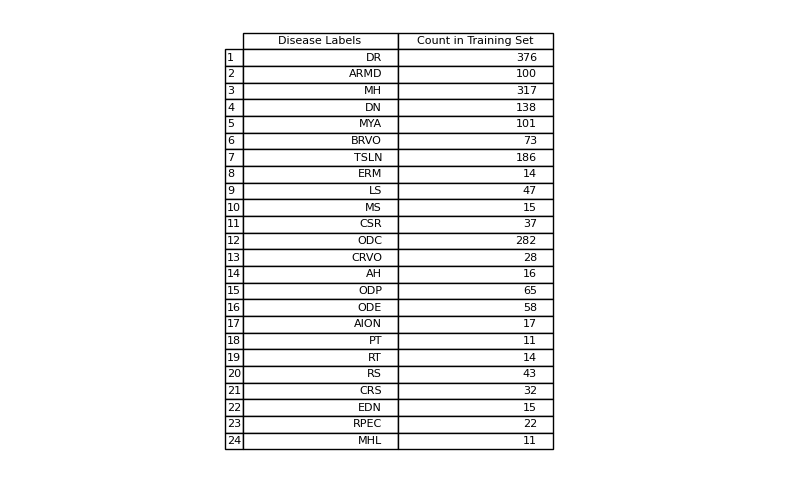

In [11]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, frame_on=False)  # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table = pd.plotting.table(ax, counts_table, loc='center', colWidths=[0.2, 0.2])

# Save the plot as a PNG image
plt.savefig('counts_table.png', bbox_inches='tight', pad_inches=0.05)

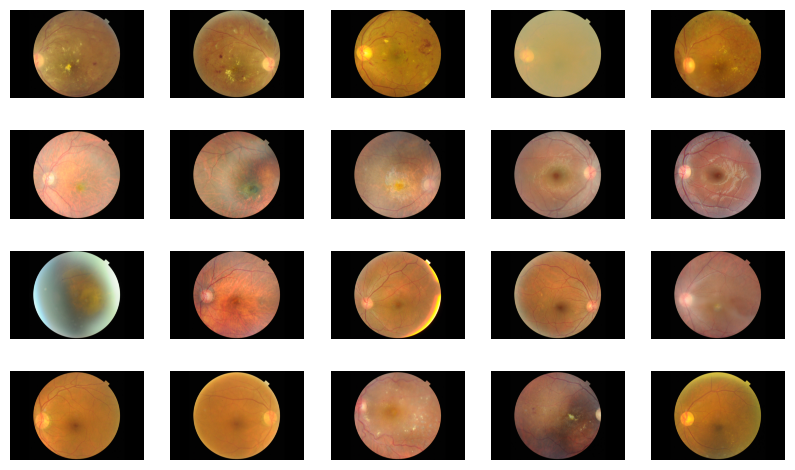

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
#selected_images = random.sample(train_df['img_path'], 10)

# Plot the images
fig, axes = plt.subplots(4, 5, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    img_path = train_df['img_path'][i]
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")
    #ax.set_title(f"Image {i + 1}")

plt.show()

In [13]:
y_train = list(train_df.drop(['img_path'], axis=1).columns)
y_val = y_train
y_test = y_train
unique_diseases = len(y_train)

In [14]:
datagen = ImageDataGenerator()

# Create data generators for training, validation, and test data
train_data = datagen.flow_from_dataframe(train_df,
                                         x_col='img_path',
                                         y_col=y_train,
                                         target_size=(356,536),
                                         class_mode='raw',
                                         batch_size=1,
                                         shuffle=False)
val_data = datagen.flow_from_dataframe(val_df,
                                       x_col='img_path',
                                       y_col=y_val,
                                       target_size=(356,536),
                                       class_mode='raw',
                                       batch_size=1)
test_data = datagen.flow_from_dataframe(test_df,
                                        x_col='img_path',
                                        y_col=y_test,
                                        target_size=(356,536),
                                        class_mode='raw',
                                        batch_size=1)

Found 1920 validated image filenames.
Found 640 validated image filenames.
Found 640 validated image filenames.


In [15]:

def extract_images_and_labels(generator):
    images_list = []
    labels_list = []

    for i in range((int)(len(generator))):
        batch_images, batch_labels = generator[i]
        images_list.append(batch_images[0])  # Assuming batch_size=1, so we take the first image
        labels_list.append(batch_labels[0])  # Assuming batch_size=1, so we take the first label

    images_array = np.array(images_list)
    labels_array = np.array(labels_list)

    return images_array, labels_array



In [16]:
train_images, train_labels = extract_images_and_labels(train_data)

In [17]:
test_images, test_labels = extract_images_and_labels(test_data)

In [18]:
val_images, val_labels = extract_images_and_labels(val_data)

In [19]:
!pip install scikit-image

In [20]:
from skimage import color

def image_rgb_to_cielab(image):
    # Convert the RGB image to LAB color space
    cielab_image = color.rgb2lab(image)
    
    # Extract the L*, a*, and b* components
    L_channel, a_channel, b_channel = cielab_image[..., 0], cielab_image[..., 1], cielab_image[..., 2]
    
    return L_channel, a_channel, b_channel


In [21]:
def conve(images):
  ltest=[]
  for i in range(len(images)):
    L_channel, a_channel, b_channel = image_rgb_to_cielab(images[i])
    ltest.append(np.stack((L_channel, a_channel,b_channel), axis=-1))
    #atest.append(a_channel)
    #btest.append(b_channel)

  return np.array(ltest)


In [22]:
new_test_images=conve(test_images)

In [23]:
new_train_images=conve(train_images)

In [24]:
new_val_images=conve(val_images)

In [25]:
#tnew_train_images[0][150][150]

In [26]:
new_train_images = new_train_images/255
new_test_images = new_test_images/255
new_val_images = new_val_images/255

In [27]:
new_train_images[1]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [28]:
recall = tf.keras.metrics.Recall(name="recall", thresholds=0.1)
acc = tf.keras.metrics.BinaryAccuracy(name="binary_acc", threshold=0.1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
auc = tf.keras.metrics.AUC(multi_label=True, name="AU-ROC", thresholds=[0,0.08,0.1])

In [31]:
def conv_batchnorm_relu(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)          
    return x

In [32]:
def identity_block(tensor, filters):
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)
    x = Add()([tensor,x]) # skip connection
    x = LeakyReLU()(x)          
    return x

In [33]:
def projection_block(tensor, filters, strides):
         
     #left stream     
     x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=strides)     
     x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)     
     x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)     
     x = BatchNormalization()(x) 
         
     #right stream     
     shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)     
     shortcut = BatchNormalization()(shortcut)          
     x = Add()([shortcut,x])    #skip connection     
     x = LeakyReLU()(x)          
     return x 

In [34]:
def setPriority(x,neurons):
    se = tf.keras.layers.GlobalAveragePooling2D()(x)
    #se = tf.keras.layers.Reshape((1, filters))(se) 
    se = tf.keras.layers.Dense(neurons)(se)
    se = tf.keras.layers.Dense(neurons)(se)
    se = tf.keras.layers.Dense(neurons)(se)
    se = tf.keras.layers.Dense(neurons, activation='sigmoid')(se)
    se = tf.keras.layers.multiply([x, se])
    return se

# x = tf.keras.Input(shape=(356,536,3))  # Replace 'channels' with the actual number of channels
# x = conv_batchnorm_relu(x, filters=64, kernel_size=7, strides=2)
# x = MaxPool2D(pool_size = 3, strides =2)(x)
# z=setPriority(x,64)

In [35]:
def resnet_block(x, filters, reps, strides):
    
    x = projection_block(x, filters, strides)
    for _ in range(reps-1):
        x = identity_block(x,filters)
    return x 

In [36]:
inputs = Input(shape=(356,536,3))
x = conv_batchnorm_relu(inputs, filters=64, kernel_size=7, strides=2)
x = MaxPool2D(pool_size = 3, strides =2)(x)
#here apply
x = setPriority(x,64)
x = resnet_block(x, filters=64, reps =3, strides=1)
x = setPriority(x,256)
#88*133* 256
x = resnet_block(x, filters=128, reps =4, strides=2)
x = setPriority(x,512)
#44*67*512
x = resnet_block(x, filters=256, reps =6, strides=2)
x = setPriority(x,1024)
#22*34*1024
x = resnet_block(x, filters=512, reps =3, strides=2)
#2048
x = GlobalAvgPool2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)

output = Dense(24, activation ='sigmoid')(x)


nmodel = tf.keras.Model(inputs=inputs, outputs=output)

In [37]:
nmodel.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 356, 536,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 178, 268,  │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 178, 268,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 178, 268,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 88, 133,   │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      4,160 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 88, 133,   │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 88, 133,   │      4,160 │ multiply[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 133,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 88, 133,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 88, 133,   │     36,928 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 133,   │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 88, 133,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 88, 133,   │     16,640 │ multiply[0][0]    │
│                     │ 256)              │            │                 

 Total params: 29,713,048 (113.35 MB)

 Trainable params: 29,659,928 (113.14 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [38]:
recall = tf.keras.metrics.Recall(name="recall", thresholds=0.1)
acc = tf.keras.metrics.BinaryAccuracy(name="binary_acc", threshold=0.1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
auc = tf.keras.metrics.AUC(multi_label=True, name="AU-ROC", thresholds=[0,0.08,0.1])

In [39]:
nmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy', metrics=[acc,recall,AUC()])

In [41]:
nmodel.fit(train_images, train_labels, batch_size=8, validation_data=(val_images, val_labels), epochs=15)

Epoch 1/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 3082s 13s/step - auc: 0.6672 - binary_acc: 0.8006 - loss: 0.3697 - recall: 0.4178 - val_auc: 0.5971 - val_binary_acc: 0.8843 - val_loss: 175.1431 - val_recall: 0.3122
Epoch 2/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 2956s 12s/step - auc: 0.7810 - binary_acc: 0.8429 - loss: 0.1613 - recall: 0.5273 - val_auc: 0.7751 - val_binary_acc: 0.8711 - val_loss: 0.1747 - val_recall: 0.3695
Epoch 3/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 2942s 12s/step - auc: 0.7743 - binary_acc: 0.8642 - loss: 0.1563 - recall: 0.4727 - val_auc: 0.7906 - val_binary_acc: 0.8795 - val_loss: 0.1514 - val_recall: 0.4314
Epoch 4/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 2895s 12s/step - auc: 0.7903 - binary_acc: 0.8514 - loss: 0.1584 - recall: 0.5070 - val_auc: 0.7899 - val_binary_acc: 0.8100 - val_loss: 0.1609 - val_recall: 0.5973
Epoch 5/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 2914s 12s/step - auc: 0.7971 - binary_acc: 0.8549 - loss: 0.1573 - recall: 0.5446 - val_auc: 0.7938 - val_binary_acc: 0.8685 - val_loss: 0.1533

In [42]:
test_accuracy = nmodel.evaluate(test_images, test_labels)

20/20 ━━━━━━━━━━━━━━━━━━━━ 199s 10s/step - auc: 0.7902 - binary_acc: 0.8712 - loss: 0.1454 - recall: 0.4866


In [43]:
nmodel.save_weights('new_weights_4_layers.weights.h5')

VGG16



In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

# Load the pre-trained ResNet50 model
base_model = VGG16(weights=None, include_top=False)

# Freeze the layers of the base model

# Define the input layer
inputs = Input(shape=(356, 536, 3))

# Apply the base model to the input
x = base_model(inputs, training=True)

# Add a global average pooling layer
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
# Add a fully connected layer with sigmoid activation for multilabel classification
outputs = Dense(unique_diseases, activation='sigmoid')(x)  # Adjust num_classes according to your dataset

# Create the model
model = Model(inputs, outputs)

# Compile the model

# Display model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 356, 536, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 11, 16, 512)    │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,917,976 (56.91 MB)

 Trainable params: 14,917,976 (56.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EfficientNetB0

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

# Load the pre-trained ResNet50 model
base_model = EfficientNetB4(weights=None, include_top=False)

# Freeze the layers of the base model

# Define the input layer
inputs = Input(shape=(356, 536, 3))

# Apply the base model to the input
x = base_model(inputs, training=True)

# Add a global average pooling layer
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
# Add a fully connected layer with sigmoid activation for multilabel classification
outputs = Dense(24, activation='sigmoid')(x)  # Adjust num_classes according to your dataset

# Create the model
model = Model(inputs, outputs)

# Compile the model

# Display model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 356, 536, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 11, 16, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,204,791 (69.45 MB)

 Trainable params: 18,079,584 (68.97 MB)

 Non-trainable params: 125,207 (489.09 KB)

InceptionV3

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

# Load the pre-trained ResNet50 model
base_model = InceptionV3(weights=None, include_top=False)

# Freeze the layers of the base model

# Define the input layer
inputs = Input(shape=(356, 536, 3))

# Apply the base model to the input
x = base_model(inputs, training=True)

# Add a global average pooling layer
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
# Add a fully connected layer with sigmoid activation for multilabel classification
outputs = Dense(unique_diseases, activation='sigmoid')(x)  # Adjust num_classes according to your dataset

# Create the model
model = Model(inputs, outputs)

# Compile the model

# Display model summary
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 356, 536, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 9, 15, 2048)    │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,399,288 (85.45 MB)

 Trainable params: 22,364,856 (85.32 MB)

 Non-trainable params: 34,432 (134.50 KB)

Xception

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

# Load the pre-trained ResNet50 model
base_model = Xception(weights=None, include_top=False)

# Freeze the layers of the base model

# Define the input layer
inputs = Input(shape=(356, 536, 3))

# Apply the base model to the input
x = base_model(inputs, training=True)

# Add a global average pooling layer
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
# Add a fully connected layer with sigmoid activation for multilabel classification
outputs = Dense(unique_diseases, activation='sigmoid')(x)  # Adjust num_classes according to your dataset

# Create the model
model = Model(inputs, outputs)

# Compile the model

# Display model summary
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 356, 536, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 11, 17, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,457,984 (81.86 MB)

 Trainable params: 21,403,456 (81.65 MB)

 Non-trainable params: 54,528 (213.00 KB)